# Physics-enhanced regression part 1

**Time-series data and optimization with ``optax``**

We create some fake-observational data, compute the marginal likelihood of this fake data _under the ODE posterior_ (which is something you cannot do with non-probabilistic solvers!), and optimize the parameters with `optax`. Tronarp, Bosch, and Hennig call this "physics-enhanced regression".

In [1]:
import functools

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from diffeqzoo import backend, ivps
from jax.config import config

from probdiffeq import dense_output, solution_routines, solvers
from probdiffeq.implementations import recipes
from probdiffeq.strategies import smoothers

config.update("jax_enable_x64", True)

if not backend.has_been_selected:
    backend.select("jax")

Create a problem and some fake-data:

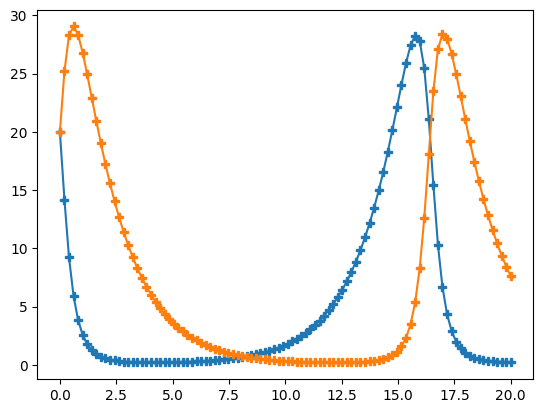

In [2]:
f, u0, (t0, t1), f_args = ivps.lotka_volterra()
f_args = jnp.asarray(f_args)

parameter_true = f_args + 0.05
parameter_guess = f_args


@jax.jit
def vf(y, t, p):
    return f(y, *p)


ts = jnp.linspace(t0, t1, endpoint=True, num=100)

strategy = smoothers.Smoother(
    recipes.IsoTS0.from_params(num_derivatives=1),
)
solver = solvers.CalibrationFreeSolver(strategy, output_scale_sqrtm=10.0)


solution_true = solution_routines.solve_fixed_grid(
    vf, initial_values=(u0,), grid=ts, solver=solver, parameters=parameter_true
)
data = solution_true.u
plt.plot(ts, data, "P-")
plt.show()

We make an initial guess, but it does not lead to a good data fit:

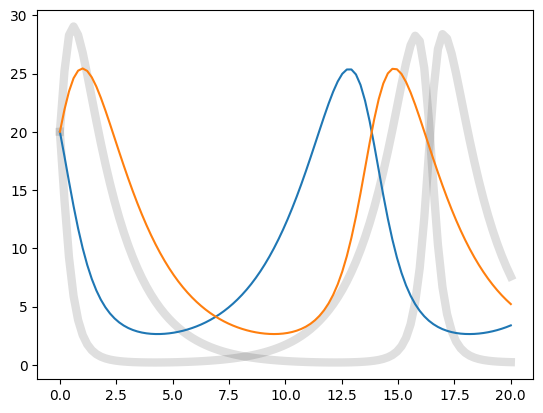

In [3]:
solution_guess = solution_routines.solve_fixed_grid(
    vf, initial_values=(u0,), grid=ts, solver=solver, parameters=parameter_guess
)
plt.plot(ts, data, color="k", linestyle="solid", linewidth=6, alpha=0.125)
plt.plot(ts, solution_guess.u)
plt.show()

Use the probdiffeq functionality to compute a parameter-to-data fit function.

This incorporates the likelihood of the data under the distribution induced by the probabilistic ODE solution (which was generated with the current parameter guess).

In [4]:
def param_to_log_likelihood(parameters_, u0_, ts_, solver_, vf_, data_, obs_stdev=1e-1):
    sol_ = solution_routines.solve_fixed_grid(
        vf_, initial_values=(u0_,), grid=ts_, solver=solver_, parameters=parameters_
    )

    observation_std = jnp.ones_like(ts_) * obs_stdev
    return dense_output.negative_marginal_log_likelihood(
        observation_std=observation_std, u=data_, solution=sol_
    )


parameter_to_data_fit = jax.jit(
    functools.partial(
        param_to_log_likelihood, solver_=solver, ts_=ts, vf_=vf, u0_=u0, data_=data
    )
)

sensitivities = jax.jit(jax.grad(parameter_to_data_fit))

We can differentiate the function forward- and reverse-mode (the latter is possible because we use fixed steps)

In [5]:
%%time

parameter_to_data_fit(parameter_guess)
sensitivities(parameter_guess)

CPU times: user 1.79 s, sys: 65.9 ms, total: 1.86 s
Wall time: 1.72 s


DeviceArray([44.80069421, 68.46055784, 51.8853719 , 24.4436413 ], dtype=float64)

Now, enter optax: build an optimizer, and optimise the parameter-to-model-fit function. The following is more or less taken from the [optax-documentation](https://optax.readthedocs.io/en/latest/optax-101.html).

In [6]:
def build_update_fn(*, optimizer, loss_fn):
    """Build a function for executing a single step in the optimization."""

    @jax.jit
    def update(params, opt_state):
        loss, grads = jax.value_and_grad(loss_fn)(params)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state

    return update


optim = optax.adam(learning_rate=1e-2)
update_fn = build_update_fn(optimizer=optim, loss_fn=parameter_to_data_fit)

In [7]:
%%time

p = parameter_guess
state = optim.init(p)

chunk_size = 10
for i in range(chunk_size):
    for _ in range(chunk_size):
        p, state = update_fn(p, state)

    print(f"After {(i+1)*chunk_size} iterations:", p)

After 10 iterations: [0.42770102 0.04292588 0.42432207 0.05171601]
After 20 iterations: [0.45728524 0.07923058 0.45694513 0.04105533]
After 30 iterations: [0.47842096 0.07985477 0.47649439 0.05473689]
After 40 iterations: [0.49708265 0.07809203 0.49330989 0.06937019]
After 50 iterations: [0.51283241 0.08063289 0.5084847  0.07971852]
After 60 iterations: [0.52474768 0.08656783 0.52079283 0.08642064]
After 70 iterations: [0.53418808 0.09178193 0.53085261 0.09029569]
After 80 iterations: [0.5407471  0.09531477 0.53777697 0.09347751]
After 90 iterations: [0.5451319  0.09723224 0.54227833 0.09613052]
After 100 iterations: [0.54793537 0.09831685 0.54512154 0.09800662]
CPU times: user 1.4 s, sys: 21.1 ms, total: 1.42 s
Wall time: 1.4 s


The solution looks much better:

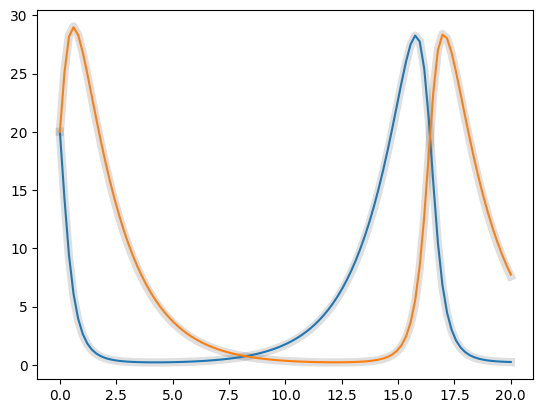

In [8]:
solution_wrong = solution_routines.solve_fixed_grid(
    vf, initial_values=(u0,), grid=ts, solver=solver, parameters=p
)
plt.plot(ts, data, color="k", linestyle="solid", linewidth=6, alpha=0.125)
plt.plot(ts, solution_wrong.u)
plt.show()